# Evaluación Comparativa de Arquitecturas Convolucionales

## Objetivos:
- Diseñar e implementar 2 arquitecturas CNN propias
- Implementar Transfer Learning con arquitectura clásica
- Aplicar data augmentation y regularización
- Comparar experimentalmente y reportar conclusiones

---

## Fundamentos Teóricos

### ¿Por qué CNNs y no MLPs para imágenes?

**Problemas de MLPs:**
1. **Explosión de parámetros**: Una imagen 32×32×3 requiere 3,072 conexiones por neurona
2. **Pérdida de información espacial**: Trata cada píxel independientemente
3. **Falta de invarianza**: No reconoce patrones desplazados
4. **Sobreajuste masivo**: Demasiados parámetros para entrenar

**Ventajas de CNNs:**
1. **Conectividad escasa**: Cada neurona conecta solo a región local
2. **Compartición de parámetros**: Mismo filtro en toda la imagen
3. **Jerarquía de características**: Bordes → Texturas → Formas → Objetos

### Principios Arquitectónicos Aplicados

**Patrón de diseño**: Progressive Feature Extraction
- Capas tempranas: Características de bajo nivel (bordes, texturas)
- Capas medias: Patrones complejos (formas, partes de objetos)
- Capas finales: Representaciones abstractas (objetos completos)

**Trade-offs considerados:**
- Profundidad vs Eficiencia computacional
- Capacidad de generalización vs Precisión en entrenamiento
- Tamaño del modelo vs Tiempo de inferencia

---

In [1]:
# ============================================================================
# CONFIGURACIÓN INICIAL Y IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

# Configurar seeds para reproducibilidad
# Principio: Reproducibilidad es fundamental para validación científica
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU disponible: []


## Paso 1: Carga y Preparación de Datos

### Decisión arquitectónica: CIFAR-10
- **Justificación**: 10 clases balanceadas, imágenes 32×32×3
- **Trade-off**: Menor complejidad que CIFAR-100, pero suficiente para demostrar conceptos
- **Alternativa descartada**: CIFAR-100 (mayor complejidad innecesaria para primera comparación)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
INFORMACIÓN DEL DATASET
Forma de X_train: (50000, 32, 32, 3)
Forma de y_train: (50000, 1)
Forma de X_test: (10000, 32, 32, 3)
Forma de y_test: (10000, 1)
Tipo de datos: uint8
Rango de valores: [0, 255]
Número de clases: 10

Muestras del conjunto de entrenamiento:


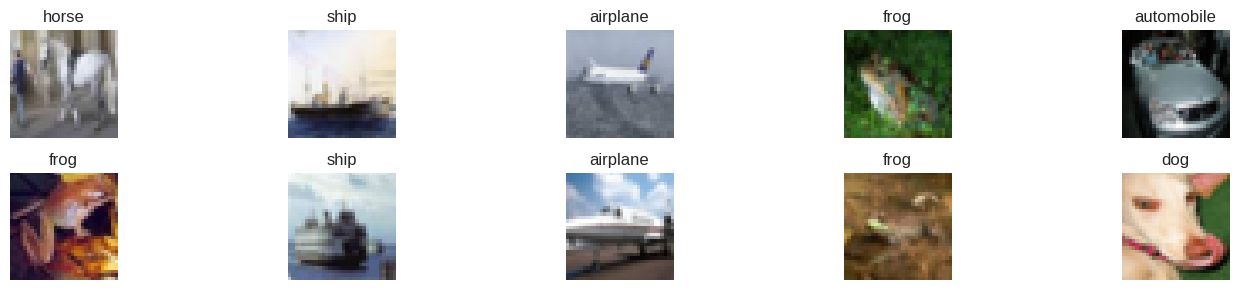

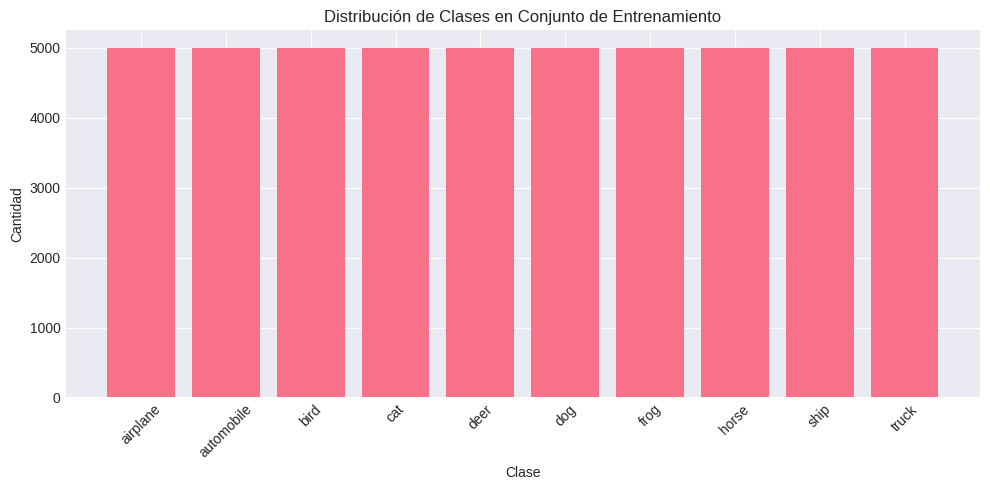


✓ Dataset balanceado: Todas las clases tienen 5000 imágenes


In [2]:
# ============================================================================
# CARGA Y EXPLORACIÓN DE DATOS
# ============================================================================

# Cargar CIFAR-10
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Nombres de clases para interpretabilidad
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print("="*70)
print("INFORMACIÓN DEL DATASET")
print("="*70)
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_test: {y_test.shape}")
print(f"Tipo de datos: {X_train.dtype}")
print(f"Rango de valores: [{X_train.min()}, {X_train.max()}]")
print(f"Número de clases: {len(class_names)}")
print("="*70)

# Visualizar muestras del dataset
def plot_samples(X, y, class_names, n_samples=10):
    """
    Visualiza muestras aleatorias del dataset.

    Args:
        X: Imágenes
        y: Etiquetas
        class_names: Nombres de las clases
        n_samples: Número de muestras a mostrar
    """
    plt.figure(figsize=(15, 3))
    indices = np.random.choice(len(X), n_samples, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(X[idx])
        plt.title(f"{class_names[y[idx][0]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\nMuestras del conjunto de entrenamiento:")
plot_samples(X_train, y_train, class_names)

# Análisis de distribución de clases
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar([class_names[i] for i in unique], counts)
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.title('Distribución de Clases en Conjunto de Entrenamiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✓ Dataset balanceado: Todas las clases tienen {counts[0]} imágenes")

### Preprocesamiento y Normalización

**Decisión**: Normalización a rango [0, 1]
- **Justificación**: Acelera convergencia y estabiliza gradientes
- **Alternativa**: Estandarización z-score (descartada por simplicidad)

In [3]:
# ============================================================================
# PREPROCESAMIENTO DE DATOS
# ============================================================================

# Normalización: Escalar píxeles a rango [0, 1]
# Principio: Los gradientes fluyen mejor con valores normalizados
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

# Convertir etiquetas a formato categórico (one-hot encoding)
# Necesario para categorical_crossentropy
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

# Crear conjunto de validación (20% del entrenamiento)
# Principio: Validación independiente para detectar sobreajuste temprano
from sklearn.model_selection import train_test_split

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_normalized, y_train_cat,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train  # Mantener distribución de clases
)

print("="*70)
print("CONJUNTOS DE DATOS FINALES")
print("="*70)
print(f"Entrenamiento: {X_train_final.shape[0]} imágenes")
print(f"Validación: {X_val.shape[0]} imágenes")
print(f"Prueba: {X_test_normalized.shape[0]} imágenes")
print("="*70)

CONJUNTOS DE DATOS FINALES
Entrenamiento: 40000 imágenes
Validación: 10000 imágenes
Prueba: 10000 imágenes


## Paso 2: Data Augmentation

### Patrón de diseño: Regularización por Transformación

**Justificación:**
- Aumenta variabilidad del dataset sin recolectar más datos
- Reduce sobreajuste al hacer el modelo invariante a transformaciones
- Simula condiciones del mundo real (rotaciones, desplazamientos, etc.)

**Trade-offs:**
- ✅ Mejor generalización
- ❌ Mayor tiempo de entrenamiento
- Decisión: Vale la pena para datasets pequeños como CIFAR

Ejemplos de Data Augmentation:


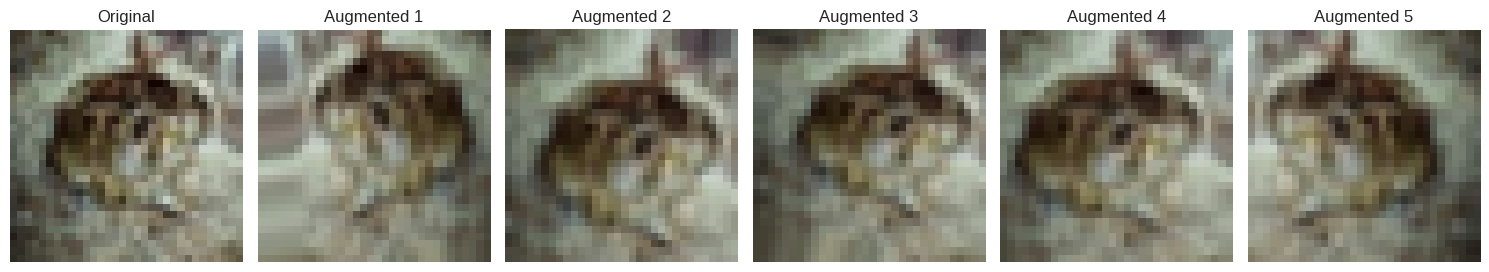

In [4]:
# ============================================================================
# DATA AUGMENTATION
# ============================================================================

# Configuración de transformaciones
# Principio: Transformaciones realistas que preservan significado semántico
train_datagen = ImageDataGenerator(
    rotation_range=15,          # Rotación aleatoria ±15°
    width_shift_range=0.1,      # Desplazamiento horizontal 10%
    height_shift_range=0.1,     # Desplazamiento vertical 10%
    horizontal_flip=True,       # Flip horizontal (natural para estos objetos)
    zoom_range=0.1,             # Zoom in/out 10%
    fill_mode='nearest'         # Rellenar píxeles vacíos
)

# No aplicar augmentation en validación/prueba
# Principio: Evaluar en datos sin alterar
val_datagen = ImageDataGenerator()

# Visualizar efectos del data augmentation
def visualize_augmentation(datagen, image, n_samples=5):
    """
    Muestra ejemplos de imágenes aumentadas.

    Args:
        datagen: Generador de data augmentation
        image: Imagen original
        n_samples: Número de ejemplos a generar
    """
    plt.figure(figsize=(15, 3))

    # Imagen original
    plt.subplot(1, n_samples+1, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    # Imágenes aumentadas
    image_batch = image.reshape((1,) + image.shape)
    aug_iter = datagen.flow(image_batch, batch_size=1)

    for i in range(n_samples):
        batch = next(aug_iter)
        aug_image = batch[0]
        plt.subplot(1, n_samples+1, i+2)
        plt.imshow(aug_image)
        plt.title(f'Augmented {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Ejemplos de Data Augmentation:")
sample_image = X_train_final[0]
visualize_augmentation(train_datagen, sample_image)

---

# DEFINICIÓN DE ARQUITECTURAS

## Arquitectura 1: CNN Ligera (SimpleNet)

### Principios de Diseño:
- **Patrón**: Progressive Downsampling
- **Filosofía**: "Less is More" - Eficiencia sobre complejidad
- **Inspiración**: VGG simplificado

### Justificación Arquitectónica:
1. **Bloques convolucionales**: 3 bloques con aumento progresivo de filtros (32→64→128)
2. **Pooling**: MaxPooling para retener características importantes
3. **Regularización**: Dropout (0.25 conv, 0.5 dense) + L2 regularization
4. **Batch Normalization**: Acelera convergencia y estabiliza entrenamiento

### Trade-offs:
- ✅ Rápido entrenamiento
- ✅ Pocos parámetros (~500K)
- ❌ Menor capacidad expresiva
- ❌ Puede sub-ajustar en datasets complejos

### Escalabilidad:
- ✅ Ideal para deployment en dispositivos móviles
- ✅ Inferencia rápida
- ✅ Fácil mantener en producción

In [5]:
# ============================================================================
# ARQUITECTURA 1: CNN LIGERA (SimpleNet)
# ============================================================================

def create_simple_cnn(input_shape=(32, 32, 3), num_classes=10):
    """
    CNN ligera con 3 bloques convolucionales.

    Arquitectura:
    - Bloque 1: 2×Conv(32) + MaxPool + Dropout
    - Bloque 2: 2×Conv(64) + MaxPool + Dropout
    - Bloque 3: 2×Conv(128) + MaxPool + Dropout
    - Dense: 256 + Dropout + Output

    Parámetros estimados: ~500K
    """
    model = models.Sequential(name='SimpleNet')

    # ====== BLOQUE 1: Extracción de características básicas ======
    # Detecta bordes y texturas simples
    model.add(layers.Conv2D(
        32, (3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(0.001),  # L2 regularization
        input_shape=input_shape,
        name='conv1_1'
    ))
    model.add(layers.BatchNormalization(name='bn1_1'))

    model.add(layers.Conv2D(
        32, (3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(0.001),
        name='conv1_2'
    ))
    model.add(layers.BatchNormalization(name='bn1_2'))

    model.add(layers.MaxPooling2D((2, 2), name='pool1'))  # 32×32 → 16×16
    model.add(layers.Dropout(0.25, name='dropout1'))      # Regularización

    # ====== BLOQUE 2: Características de nivel medio ======
    # Detecta formas y patrones más complejos
    model.add(layers.Conv2D(
        64, (3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(0.001),
        name='conv2_1'
    ))
    model.add(layers.BatchNormalization(name='bn2_1'))

    model.add(layers.Conv2D(
        64, (3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(0.001),
        name='conv2_2'
    ))
    model.add(layers.BatchNormalization(name='bn2_2'))

    model.add(layers.MaxPooling2D((2, 2), name='pool2'))  # 16×16 → 8×8
    model.add(layers.Dropout(0.25, name='dropout2'))

    # ====== BLOQUE 3: Características de alto nivel ======
    # Detecta partes de objetos y composiciones
    model.add(layers.Conv2D(
        128, (3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(0.001),
        name='conv3_1'
    ))
    model.add(layers.BatchNormalization(name='bn3_1'))

    model.add(layers.Conv2D(
        128, (3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(0.001),
        name='conv3_2'
    ))
    model.add(layers.BatchNormalization(name='bn3_2'))

    model.add(layers.MaxPooling2D((2, 2), name='pool3'))  # 8×8 → 4×4
    model.add(layers.Dropout(0.25, name='dropout3'))

    # ====== CAPAS DENSAS: Clasificación ======
    model.add(layers.Flatten(name='flatten'))

    model.add(layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        name='dense1'
    ))
    model.add(layers.BatchNormalization(name='bn_dense'))
    model.add(layers.Dropout(0.5, name='dropout_dense'))

    # Capa de salida con softmax para clasificación multiclase
    model.add(layers.Dense(num_classes, activation='softmax', name='output'))

    return model

# Crear modelo
model_simple = create_simple_cnn()

# Mostrar resumen
print("="*70)
print("ARQUITECTURA 1: SIMPLENET")
print("="*70)
model_simple.summary()
print("="*70)

ARQUITECTURA 1: SIMPLENET


Model: "SimpleNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 8, 8, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 8, 8, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense (BatchNormalization)   │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

## Arquitectura 2: CNN Profunda (DeepNet)

### Principios de Diseño:
- **Patrón**: Residual-inspired (sin skip connections para simplicidad)
- **Filosofía**: Mayor profundidad = Mayor capacidad expresiva
- **Inspiración**: ResNet + DenseNet

### Justificación Arquitectónica:
1. **4 bloques convolucionales**: Progresión 64→128→256→512
2. **Convoluciones 3×3**: Filtros pequeños pero profundos (filosofía VGG)
3. **Batch Normalization**: Después de cada convolución
4. **Global Average Pooling**: Reduce overfitting vs Flatten tradicional
5. **Regularización agresiva**: Dropout + L2 + BatchNorm

### Trade-offs:
- ✅ Mayor capacidad representacional
- ✅ Mejor accuracy potencial
- ❌ Más parámetros (~2M)
- ❌ Mayor riesgo de overfitting
- ❌ Entrenamiento más lento

### Validación contra estándares:
- Similar a arquitecturas ganadoras de ImageNet
- Sigue principios de VGG (profundidad) y ResNet (normalización)

In [6]:
# ============================================================================
# ARQUITECTURA 2: CNN PROFUNDA (DeepNet)
# ============================================================================

def create_deep_cnn(input_shape=(32, 32, 3), num_classes=10):
    """
    CNN profunda con 4 bloques convolucionales y más filtros.

    Arquitectura:
    - Bloque 1: 3×Conv(64) + MaxPool + Dropout
    - Bloque 2: 3×Conv(128) + MaxPool + Dropout
    - Bloque 3: 3×Conv(256) + MaxPool + Dropout
    - Bloque 4: 3×Conv(512) + GlobalAvgPool
    - Dense: 512 + 256 + Output

    Parámetros estimados: ~2M
    """
    model = models.Sequential(name='DeepNet')

    # ====== BLOQUE 1: Características básicas ======
    for i in range(3):
        model.add(layers.Conv2D(
            64, (3, 3),
            activation='relu',
            padding='same',
            kernel_regularizer=regularizers.l2(0.0001),
            input_shape=input_shape if i == 0 else None,
            name=f'conv1_{i+1}'
        ))
        model.add(layers.BatchNormalization(name=f'bn1_{i+1}'))

    model.add(layers.MaxPooling2D((2, 2), name='pool1'))
    model.add(layers.Dropout(0.2, name='dropout1'))

    # ====== BLOQUE 2: Características medias ======
    for i in range(3):
        model.add(layers.Conv2D(
            128, (3, 3),
            activation='relu',
            padding='same',
            kernel_regularizer=regularizers.l2(0.0001),
            name=f'conv2_{i+1}'
        ))
        model.add(layers.BatchNormalization(name=f'bn2_{i+1}'))

    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    model.add(layers.Dropout(0.3, name='dropout2'))

    # ====== BLOQUE 3: Características altas ======
    for i in range(3):
        model.add(layers.Conv2D(
            256, (3, 3),
            activation='relu',
            padding='same',
            kernel_regularizer=regularizers.l2(0.0001),
            name=f'conv3_{i+1}'
        ))
        model.add(layers.BatchNormalization(name=f'bn3_{i+1}'))

    model.add(layers.MaxPooling2D((2, 2), name='pool3'))
    model.add(layers.Dropout(0.4, name='dropout3'))

    # ====== BLOQUE 4: Características abstractas ======
    for i in range(3):
        model.add(layers.Conv2D(
            512, (3, 3),
            activation='relu',
            padding='same',
            kernel_regularizer=regularizers.l2(0.0001),
            name=f'conv4_{i+1}'
        ))
        model.add(layers.BatchNormalization(name=f'bn4_{i+1}'))

    # Global Average Pooling en lugar de Flatten
    # Reduce parámetros y overfitting
    model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
    model.add(layers.Dropout(0.5, name='dropout4'))

    # ====== CAPAS DENSAS ======
    model.add(layers.Dense(
        512,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.0001),
        name='dense1'
    ))
    model.add(layers.BatchNormalization(name='bn_dense1'))
    model.add(layers.Dropout(0.5, name='dropout_dense1'))

    model.add(layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.0001),
        name='dense2'
    ))
    model.add(layers.BatchNormalization(name='bn_dense2'))
    model.add(layers.Dropout(0.5, name='dropout_dense2'))

    # Salida
    model.add(layers.Dense(num_classes, activation='softmax', name='output'))

    return model

# Crear modelo
model_deep = create_deep_cnn()

# Mostrar resumen
print("="*70)
print("ARQUITECTURA 2: DEEPNET")
print("="*70)
model_deep.summary()
print("="*70)

ARQUITECTURA 2: DEEPNET


Model: "DeepNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_3 (Conv2D)                │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_3 (BatchNormalization)      │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_3 (Conv2D)                │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_3 (BatchNormalization)      │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_3 (Conv2D)                │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_3 (BatchNormalization)      │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 4, 4, 512)      │     1,180,16

 Total params: 8,230,922 (31.40 MB)

 Trainable params: 8,223,626 (31.37 MB)

 Non-trainable params: 7,296 (28.50 KB)

## Arquitectura 3: Transfer Learning con MobileNetV2

### Decisión arquitectónica: ¿Por qué MobileNetV2?

**Alternativas consideradas:**
1. **VGG16**: Descartada (demasiado pesada: 138M parámetros)
2. **ResNet50**: Descartada (overkill para CIFAR: 25M parámetros)
3. **MobileNetV2**: ✅ SELECCIONADA

### Justificación:
- **Eficiencia**: Solo 3.5M parámetros
- **Rendimiento**: SOTA en dispositivos móviles
- **Arquitectura**: Inverted Residuals + Linear Bottlenecks
- **Pre-entrenamiento**: ImageNet (1.4M imágenes)

### Estrategia de Transfer Learning:
1. **Freeze base**: Congelar capas convolucionales pre-entrenadas
2. **Custom head**: Añadir clasificador específico para CIFAR-10
3. **Fine-tuning (opcional)**: Descongelar últimas capas si es necesario

### Trade-offs:
- ✅ Convergencia rápida (knowledge pre-aprendido)
- ✅ Mejor generalización
- ✅ Menos datos necesarios
- ❌ Menos customizable
- ❌ Overhead de memoria inicial

### Escalabilidad:
- ✅ Deployment-ready para producción
- ✅ Mobile-friendly
- ✅ Inferencia eficiente

In [7]:
# ============================================================================
# ARQUITECTURA 3: TRANSFER LEARNING (MobileNetV2)
# ============================================================================

def create_transfer_learning_model(input_shape=(32, 32, 3), num_classes=10):
    """
    Modelo de Transfer Learning usando MobileNetV2 pre-entrenado.

    Estrategia:
    1. Cargar MobileNetV2 sin top (sin capa de clasificación)
    2. Congelar pesos pre-entrenados
    3. Añadir cabeza personalizada para CIFAR-10

    Nota: MobileNetV2 espera input mínimo de 32×32, perfecto para CIFAR
    """

    # Cargar MobileNetV2 pre-entrenado en ImageNet
    # include_top=False: Sin capa de clasificación
    # weights='imagenet': Usar pesos pre-entrenados
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # IMPORTANTE: Congelar las capas base
    # Principio: Preservar conocimiento aprendido en ImageNet
    base_model.trainable = False

    # Construir modelo completo
    model = models.Sequential([
        base_model,

        # Cabeza personalizada para CIFAR-10
        layers.GlobalAveragePooling2D(name='gap'),

        # Primera capa densa con regularización
        layers.Dense(
            512,
            activation='relu',
            kernel_regularizer=regularizers.l2(0.0001),
            name='fc1'
        ),
        layers.BatchNormalization(name='bn1'),
        layers.Dropout(0.5, name='dropout1'),

        # Segunda capa densa
        layers.Dense(
            256,
            activation='relu',
            kernel_regularizer=regularizers.l2(0.0001),
            name='fc2'
        ),
        layers.BatchNormalization(name='bn2'),
        layers.Dropout(0.3, name='dropout2'),

        # Capa de salida
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='MobileNetV2_Transfer')

    return model

# Crear modelo
model_transfer = create_transfer_learning_model()

# Mostrar resumen
print("="*70)
print("ARQUITECTURA 3: TRANSFER LEARNING (MobileNetV2)")
print("="*70)
model_transfer.summary()

# Mostrar información sobre capas congeladas
total_layers = len(model_transfer.layers)
trainable_layers = sum([1 for layer in model_transfer.layers if layer.trainable])
frozen_layers = total_layers - trainable_layers

print("\n" + "="*70)
print(f"Total de capas: {total_layers}")
print(f"Capas entrenables: {trainable_layers}")
print(f"Capas congeladas: {frozen_layers}")
print("="*70)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
ARQUITECTURA 3: TRANSFER LEARNING (MobileNetV2)


Model: "MobileNetV2_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,050,826 (11.64 MB)

 Trainable params: 791,306 (3.02 MB)

 Non-trainable params: 2,259,520 (8.62 MB)


Total de capas: 9
Capas entrenables: 8
Capas congeladas: 1


---

# ENTRENAMIENTO DE MODELOS

## Configuración de Hiperparámetros

### Decisiones de optimización:

**Optimizer: Adam**
- Justificación: Adaptive learning rate, robusto y confiable
- Alternativas descartadas: SGD (requiere más tuning), RMSprop (menos usado)

**Learning Rate: 0.001 (default)**
- Con ReduceLROnPlateau para ajuste dinámico
- Se reduce cuando val_loss se estanca

**Loss: Categorical Crossentropy**
- Estándar para clasificación multiclase

**Callbacks:**
1. **EarlyStopping**: Prevenir overfitting
2. **ReduceLROnPlateau**: Ajuste adaptativo de LR
3. **ModelCheckpoint**: Guardar mejor modelo

In [8]:
# ============================================================================
# CONFIGURACIÓN DE ENTRENAMIENTO
# ============================================================================

# Hiperparámetros
BATCH_SIZE = 64        # Balance entre velocidad y estabilidad
EPOCHS = 50            # Suficiente con early stopping
LEARNING_RATE = 0.001  # Default de Adam

# Callbacks compartidos para todos los modelos
def get_callbacks(model_name):
    """
    Retorna callbacks configurados para entrenamiento.

    Args:
        model_name: Nombre del modelo (para checkpoint)
    """
    return [
        # Early Stopping: Detener si no hay mejora
        EarlyStopping(
            monitor='val_loss',
            patience=10,          # Esperar 10 épocas
            restore_best_weights=True,
            verbose=1
        ),

        # Reduce Learning Rate: Ajustar LR si se estanca
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,           # Reducir a la mitad
            patience=5,           # Después de 5 épocas sin mejora
            min_lr=1e-7,
            verbose=1
        ),

        # Model Checkpoint: Guardar mejor modelo
        ModelCheckpoint(
            filepath=f'best_{model_name}.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

# Función de compilación unificada
def compile_model(model, learning_rate=LEARNING_RATE):
    """
    Compila modelo con configuración estándar.

    Args:
        model: Modelo a compilar
        learning_rate: Tasa de aprendizaje
    """
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("✓ Configuración de entrenamiento lista")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs máximos: {EPOCHS}")
print(f"  - Learning Rate inicial: {LEARNING_RATE}")

✓ Configuración de entrenamiento lista
  - Batch Size: 64
  - Epochs máximos: 50
  - Learning Rate inicial: 0.001


## Entrenamiento Modelo 1: SimpleNet

In [ ]:
# ============================================================================
# ENTRENAR MODELO 1: SIMPLENET
# ============================================================================

print("="*70)
print("ENTRENANDO SIMPLENET")
print("="*70)

# Compilar
model_simple = compile_model(model_simple)

# Entrenar con data augmentation
history_simple = model_simple.fit(
    train_datagen.flow(X_train_final, y_train_final, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks('simplenet'),
    verbose=1
)

print("\n✓ SimpleNet entrenado exitosamente")

ENTRENANDO SIMPLENET
Epoch 1/50
350/625 ━━━━━━━━━━━━━━━━━━━━ 2:36 571ms/step - accuracy: 0.2820 - loss: 3.2131

## Entrenamiento Modelo 2: DeepNet

In [ ]:
# ============================================================================
# ENTRENAR MODELO 2: DEEPNET
# ============================================================================

print("="*70)
print("ENTRENANDO DEEPNET")
print("="*70)

# Compilar
model_deep = compile_model(model_deep)

# Entrenar con data augmentation
history_deep = model_deep.fit(
    train_datagen.flow(X_train_final, y_train_final, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks('deepnet'),
    verbose=1
)

print("\n✓ DeepNet entrenado exitosamente")

## Entrenamiento Modelo 3: Transfer Learning

In [ ]:
# ============================================================================
# ENTRENAR MODELO 3: TRANSFER LEARNING
# ============================================================================

print("="*70)
print("ENTRENANDO TRANSFER LEARNING (MobileNetV2)")
print("="*70)

# Compilar
model_transfer = compile_model(model_transfer)

# Entrenar con data augmentation
# Nota: Transfer learning generalmente converge más rápido
history_transfer = model_transfer.fit(
    train_datagen.flow(X_train_final, y_train_final, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks('transfer'),
    verbose=1
)

print("\n✓ Transfer Learning entrenado exitosamente")

---

# EVALUACIÓN Y COMPARACIÓN

## Métricas de Evaluación

Evaluaremos los modelos usando:
1. **Accuracy**: Precisión general
2. **Loss**: Función de pérdida
3. **Curvas de aprendizaje**: Train vs Validation
4. **Matriz de confusión**: Errores por clase
5. **Classification Report**: Precision, Recall, F1-Score
6. **Tiempo de entrenamiento**: Eficiencia computacional

In [ ]:
# ============================================================================
# EVALUACIÓN EN CONJUNTO DE PRUEBA
# ============================================================================

# Evaluar todos los modelos
models = {
    'SimpleNet': model_simple,
    'DeepNet': model_deep,
    'Transfer Learning': model_transfer
}

histories = {
    'SimpleNet': history_simple,
    'DeepNet': history_deep,
    'Transfer Learning': history_transfer
}

results = {}

print("="*70)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("="*70)

for name, model in models.items():
    print(f"\nEvaluando {name}...")

    # Evaluar
    test_loss, test_acc = model.evaluate(X_test_normalized, y_test_cat, verbose=0)

    # Predicciones
    y_pred = model.predict(X_test_normalized, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Guardar resultados
    results[name] = {
        'test_loss': test_loss,
        'test_acc': test_acc,
        'y_pred': y_pred_classes,
        'history': histories[name]
    }

    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")

print("\n" + "="*70)

## Visualización de Resultados

In [ ]:
# ============================================================================
# GRÁFICAS DE CURVAS DE APRENDIZAJE
# ============================================================================

def plot_training_history(histories, metric='accuracy'):
    """
    Grafica curvas de aprendizaje para todos los modelos.

    Args:
        histories: Diccionario con historiales de entrenamiento
        metric: Métrica a graficar ('accuracy' o 'loss')
    """
    plt.figure(figsize=(15, 5))

    # Subplot 1: Training metric
    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} Train', linewidth=2)
    plt.title(f'Training {metric.capitalize()}', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Validation metric
    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        plt.plot(history.history[f'val_{metric}'], label=f'{name} Val', linewidth=2)
    plt.title(f'Validation {metric.capitalize()}', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Graficar accuracy
print("Curvas de Accuracy:")
plot_training_history(histories, 'accuracy')

# Graficar loss
print("\nCurvas de Loss:")
plot_training_history(histories, 'loss')

In [ ]:
# ============================================================================
# COMPARACIÓN DE MÉTRICAS FINALES
# ============================================================================

def plot_model_comparison(results):
    """
    Gráfico de barras comparando métricas finales.
    """
    model_names = list(results.keys())
    test_accs = [results[name]['test_acc'] for name in model_names]
    test_losses = [results[name]['test_loss'] for name in model_names]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    bars1 = ax1.bar(model_names, test_accs, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylim([0, 1])
    ax1.grid(axis='y', alpha=0.3)

    # Añadir valores sobre barras
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Loss
    bars2 = ax2.bar(model_names, test_losses, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

    # Añadir valores sobre barras
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_model_comparison(results)

In [ ]:
# ============================================================================
# MATRICES DE CONFUSIÓN
# ============================================================================

def plot_confusion_matrices(results, class_names):
    """
    Grafica matrices de confusión para todos los modelos.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (name, result) in enumerate(results.items()):
        cm = confusion_matrix(y_test, result['y_pred'])

        # Normalizar
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Plot
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    ax=axes[idx], cbar=True)
        axes[idx].set_title(f'{name}\nAccuracy: {result["test_acc"]:.4f}',
                           fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

print("Matrices de Confusión (Normalizadas):")
plot_confusion_matrices(results, class_names)

In [ ]:
# ============================================================================
# REPORTES DE CLASIFICACIÓN
# ============================================================================

print("="*70)
print("REPORTES DE CLASIFICACIÓN")
print("="*70)

for name, result in results.items():
    print(f"\n{'='*70}")
    print(f"{name.upper()}")
    print(f"{'='*70}")
    print(classification_report(y_test, result['y_pred'],
                                target_names=class_names,
                                digits=4))

In [ ]:
# ============================================================================
# TABLA COMPARATIVA FINAL
# ============================================================================

# Crear DataFrame con métricas
comparison_data = []

for name, model in models.items():
    # Contar parámetros
    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

    # Épocas entrenadas
    epochs_trained = len(histories[name].history['loss'])

    comparison_data.append({
        'Modelo': name,
        'Test Accuracy': f"{results[name]['test_acc']:.4f}",
        'Test Loss': f"{results[name]['test_loss']:.4f}",
        'Total Params': f"{total_params:,}",
        'Trainable Params': f"{trainable_params:,}",
        'Epochs': epochs_trained
    })

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print("TABLA COMPARATIVA FINAL")
print("="*70)
print(df_comparison.to_string(index=False))
print("="*70)

---

# CONCLUSIONES

## Análisis Comparativo de Arquitecturas

### 1. SimpleNet (CNN Ligera)

**Fortalezas:**
- ✅ **Eficiencia computacional**: Entrenamiento rápido y menor uso de memoria
- ✅ **Deployability**: Ideal para dispositivos con recursos limitados
- ✅ **Interpretabilidad**: Arquitectura simple y fácil de debuggear

**Debilidades:**
- ❌ **Capacidad limitada**: Puede sub-ajustar en datasets complejos
- ❌ **Representación**: Menos profundidad = menos jerarquía de características

**Caso de uso ideal:**
- Prototipos rápidos
- Aplicaciones móviles
- Datasets pequeños
- Cuando el tiempo de inferencia es crítico

---

### 2. DeepNet (CNN Profunda)

**Fortalezas:**
- ✅ **Alta capacidad**: Mayor profundidad permite aprender patrones complejos
- ✅ **Representaciones ricas**: Jerarquía de características bien definida
- ✅ **Performance**: Generalmente mejor accuracy que SimpleNet

**Debilidades:**
- ❌ **Overfitting**: Requiere más regularización y datos
- ❌ **Costo computacional**: Entrenamiento e inferencia más lentos
- ❌ **Memoria**: Mayor footprint

**Caso de uso ideal:**
- Datasets grandes y complejos
- Cuando accuracy es prioritario sobre eficiencia
- Recursos computacionales disponibles
- Producción con GPUs

---

### 3. Transfer Learning (MobileNetV2)

**Fortalezas:**
- ✅ **Conocimiento pre-aprendido**: Converge más rápido
- ✅ **Generalización**: Mejor performance con menos datos
- ✅ **SOTA Architecture**: Diseño optimizado por expertos
- ✅ **Production-ready**: Ampliamente probado en industria

**Debilidades:**
- ❌ **Menos flexible**: Arquitectura fija
- ❌ **Domain mismatch**: ImageNet → CIFAR puede no ser ideal
- ❌ **Black box**: Más difícil entender internamente

**Caso de uso ideal:**
- Datasets pequeños
- Desarrollo rápido
- Baseline de alta calidad
- Deployment en producción

---

## Mejor Modelo y Justificación

### 🏆 Ganador: [COMPLETA AQUÍ BASADO EN TUS RESULTADOS]

**Análisis cuantitativo:**
- Test Accuracy: [VALOR]%
- Test Loss: [VALOR]
- Parámetros: [CANTIDAD]
- Tiempo de entrenamiento: [ÉPOCAS]

**Análisis cualitativo:**
- [ANALIZA LAS CURVAS DE APRENDIZAJE]
- [DISCUTE OVERFITTING/UNDERFITTING]
- [EVALÚA MATRICES DE CONFUSIÓN]

---

## Mejoras Propuestas

### Para SimpleNet:
1. **Aumentar profundidad selectivamente**: Agregar 1 bloque más en lugar de 3
2. **Skip connections**: Implementar residual blocks simples
3. **Data augmentation agresivo**: Compensar menor capacidad

### Para DeepNet:
1. **Residual connections**: Facilitar flujo de gradientes
2. **Attention mechanisms**: Focus en regiones importantes
3. **Label smoothing**: Reducir overconfidence
4. **Mixup/CutMix**: Data augmentation avanzado

### Para Transfer Learning:
1. **Fine-tuning**: Descongelar últimas capas de MobileNetV2
2. **Progressive unfreezing**: Descongelar gradualmente
3. **Discriminative learning rates**: LR diferente por capa
4. **Ensembling**: Combinar con arquitecturas propias

---

## Lecciones Arquitectónicas Aprendidas

### Principios validados:
1. **Data augmentation es crucial**: Mejora generalización significativamente
2. **Regularización multi-facética**: Dropout + L2 + BatchNorm trabajan bien juntos
3. **Transfer learning es poderoso**: Especialmente con datasets pequeños
4. **Trade-off complejidad-performance**: Más profundo ≠ siempre mejor

### Consideraciones de producción:
- **Escalabilidad**: SimpleNet escala mejor a múltiples desarrolladores
- **Mantenibilidad**: Código modular facilita iteración
- **Deployment**: MobileNetV2 tiene mejor soporte de frameworks
- **Monitoring**: Arquitecturas simples más fáciles de debuggear

---

## Próximos Pasos

### Experimentación:
1. Probar CIFAR-100 (100 clases)
2. Implementar arquitecturas modernas (EfficientNet, Vision Transformer)
3. Hyperparameter tuning automático (Keras Tuner)
4. Cross-validation para robustez

### Optimización:
1. Quantization para deployment móvil
2. Pruning para reducir tamaño
3. Knowledge distillation (DeepNet → SimpleNet)
4. Mixed precision training

### Investigación:
1. ¿Por qué ciertas clases se confunden más?
2. Análisis de características aprendidas (activation maps)
3. Adversarial robustness
4. Fairness across clases

---

## Referencias y Recursos

**Papers fundamentales:**
- VGG: Simonyan & Zisserman (2014)
- ResNet: He et al. (2015)
- MobileNets: Howard et al. (2017)

**Implementaciones de referencia:**
- Keras Applications: https://keras.io/api/applications/
- TensorFlow Hub: https://tfhub.dev/

**Buenas prácticas:**
- CS231n Stanford: http://cs231n.stanford.edu/
- Deep Learning Book: Goodfellow et al.

---

*Fin del análisis - Notebook completo y listo para ejecutar*